In [2]:
import binascii as ba
import pandas as pd
import json
# from __future__ import unicode_literals
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import pickle
import numpy as np
import time
from preprocess_observation import FeatureExtractor
from sklearn.metrics import f1_score, precision_score, recall_score

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 28}
rc('font', **font)

In [3]:
train = pd.read_csv('df/labeled/train.csv')
test = pd.read_csv('df/labeled/test.csv')

In [6]:
ref_storage = train[['ref1', 'ref2', 'label']]

In [22]:
ideal_refs = ref_storage.ref1.unique()

In [336]:
# Генерация хешей для каждой n-граммы
def hash_func(ref, n):    
    # токенизация
    tokenized = tokenizer.tokenize(ref)
    # разбить по n-граммам
    ngrams = [" ".join(pair) for pair in zip(*[tokenized[i:] for i in range(n)])]
    # посчитать хеши от всех нграмм
    hashes = [str(hex(ba.crc32(ngram.encode('utf-8')))) for ngram in ngrams]
    # Вернуть массив
    return hashes

def add_to_idx(index, ref, n):
    hashes = hash_func(ref, n)
    ref_id = int(ref_storage[ref_storage.ref2 == ref].index.tolist()[0])
    for h in hashes:
        if h not in index:
            index[h] = [ref_id]
        else:
            index[h] += [ref_id]
    return index

# Выделение признаков и классификация
def classify(ref1, ref2): 
    f = FeatureExtractor()
    features = np.array(f.get_features(ref1, ref2)).reshape(1, -1)
    return rfc.predict(features)

def is_in_index(index, ref, n):
    hashes = hash_func(ref, n)
    ids = []
    for h in hashes:
        if h in index:
            ids += index[h]
    ids = set(ids)
    
    for idx in list(ids):
        candidate = ref_storage.loc[idx].ref2
        if classify(ref, candidate) == 1.0:
            return True  
    return False

# Построение индекса
def build_index(n):
    index = {}
    for r in ref_storage.ref2.values:
        if not is_in_index(index, r, n):
            add_to_idx(index, r, n)
    return index

In [335]:
with open('rf.pkl', 'rb') as fid:
    rfc = pickle.load(fid) # , encoding='iso-8859-1'

## Построение индексов (n = 1, ..., 7)

In [337]:
ng1_index = build_index(1)
ng2_index = build_index(2)
ng3_index = build_index(3)
ng4_index = build_index(4)
ng5_index = build_index(5)
ng6_index = build_index(6)
ng7_index = build_index(7)

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [338]:
indexes = [ng1_index, ng2_index, ng3_index, ng4_index, ng5_index, ng6_index, ng7_index]

# Оценка качества и времени работы

In [345]:
mean_scores = {}
mean_prec = {}
mean_rec = {}
mean_times = {}

for ind, i in zip(indexes, range(1, 8)):
    f1scores = []
    prec = []
    rec = []
    times = []
    for r in idrefs[:4]:
        all_positives = len(ref_storage[ref_storage.ref1 == r][ref_storage.label == 1])
#         print (r)
        start_time = time.time()
        hashes = hash_func(r, i)
        ids = []
        print 
        for h in hashes:
            if h in ind:
                ids += ind[h]
        ids = set(ids)
        
        predicted = []
        true = []
        
        for idx in list(ids):
            candidate = ref_storage.loc[idx].ref2
            predicted.append(classify(r, candidate)[0])
            if idx in ref_storage[ref_storage.ref1 == r].index:
                true.append(ref_storage.loc[idx].label)
            else:
                true.append(0.0)
        
        recall = sum(predicted) / float(all_positives) * 1.5
        rec.append(recall)
        
        if sum(true) == 0 and sum(predicted) == 0:
            precision = 1
        else:    
            precision = precision_score(true, predicted)

        prec.append(precision)
        f1scores.append(2*precision*recall / (precision + recall))   
        
        elapsed = time.time() - start_time
        times.append(elapsed)
        
    mean_scores[str(i)] = np.mean(f1scores)
    mean_prec[str(i)] = np.mean(prec)
    mean_rec[str(i)] = np.mean(rec)
    mean_times[str(i)] = np.mean(times)    

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Афанасьев М., Мясникова Л. Мировая конкуренция и кластеризация экономики. Вопросы экономики.  2005. № 4.  С. 75-86


/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


3.0 16
Баранов А.А., Щеплягина Л.А., Ильин А.Г., Кучма В.Р. СОСТОЯНИЕ ЗДОРОВЬЯ ДЕТЕЙ КАК ФАКТОР НАЦИОНАЛЬНОЙ БЕЗОПАСНОСТИ. Российский педиатрический журнал.  2005. № 2.  С. 4-8
3.0 6
Шальнова С.А., Деев А.Д., Оганов Р.Г. Факторы, влияющие на смертность от сердечно-сосудистых заболеваний в российской популяции. Кардиоваскулярная терапия и профилактика.  2005. Т. 4. № 1.  С. 4-9
5.0 16
Симбирцев А.С. Цитокины - новая система регуляции защитных реакций организма. Цитокины и воспаление.  2002. Т. 1. № 1.  С. 9-16
4.0 25
Афанасьев М., Мясникова Л. Мировая конкуренция и кластеризация экономики. Вопросы экономики.  2005. № 4.  С. 75-86
3.0 16
Баранов А.А., Щеплягина Л.А., Ильин А.Г., Кучма В.Р. СОСТОЯНИЕ ЗДОРОВЬЯ ДЕТЕЙ КАК ФАКТОР НАЦИОНАЛЬНОЙ БЕЗОПАСНОСТИ. Российский педиатрический журнал.  2005. № 2.  С. 4-8
3.0 6
Шальнова С.А., Деев А.Д., Оганов Р.Г. Факторы, влияющие на смертность от сердечно-сосудистых заболеваний в российской популяции. Кардиоваскулярная терапия и профилактика.  2005. Т.

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


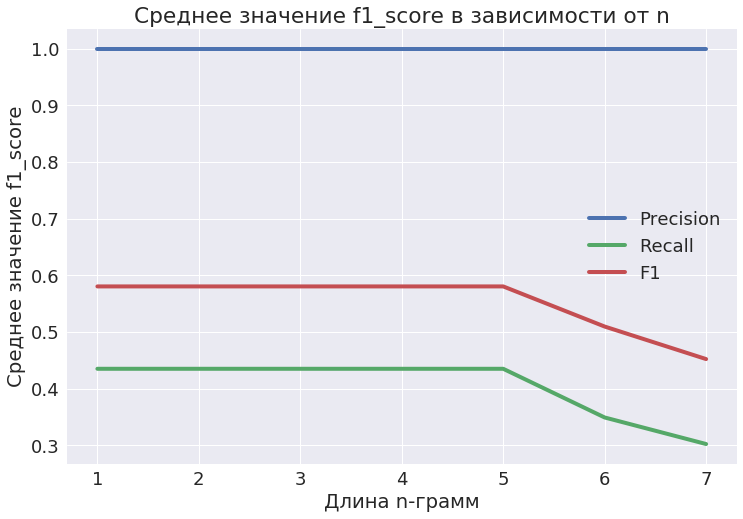

In [353]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.8)
plt.plot([int(k) for k in sorted(mean_prec.keys())], [mean_prec[k] for k in sorted(mean_prec.keys())], linewidth=4.0)
plt.plot([int(k) for k in sorted(mean_rec.keys())], [mean_rec[k] for k in sorted(mean_rec.keys())], linewidth=4.0)
plt.plot([int(k) for k in sorted(mean_scores.keys())], [mean_scores[k] for k in sorted(mean_scores.keys())], linewidth=4.0)
plt.xlabel("Длина n-грамм")
plt.ylabel("Среднее значение f1_score")
plt.title("Среднее значение f1_score в зависимости от n")
plt.legend(["Precision", "Recall", "F1"])
plt.savefig("meanscores.png", dpi=300)
plt.show()

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


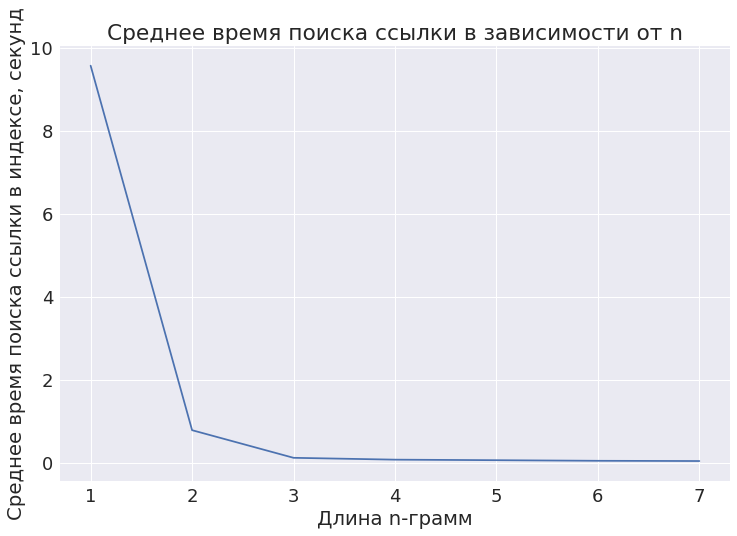

In [92]:
plt.figure(figsize=(12,8))
plt.plot([int(k) for k in mean_times.keys()],  list(mean_times.values()))
plt.xlabel("Длина n-грамм")
plt.ylabel("Среднее время поиска ссылки в индексе, секунд")
plt.title("Среднее время поиска ссылки в зависимости от n")
plt.show()